In [20]:
### import libraries
from sklearn.cluster import SpectralClustering
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import figure
from adjustText import adjust_text
from node2vec import Node2Vec
from gensim import models
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [32]:
# read data
raw_data = pd.read_csv('./Data/associations.csv', squeeze=True, sep="\a")
df = raw_data.str.split(",", n=-1, expand=True)
df.columns = ['from', 'to', 'weight', 'weight1']
df = df.drop('weight1', axis=1)

## delete numbers
df[['from', 'to']] = df[['from', 'to']].replace('\d+', '', regex=True)
df = df[df['from'].astype(bool)]                                                                                                                  
df = df[df['to'].astype(bool)]   


#specify types
df = df.astype(str)
df['weight'] = pd.to_numeric(df['weight'])

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109676 entries, 0 to 111827
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   from    109676 non-null  object 
 1   to      109676 non-null  object 
 2   weight  109676 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.3+ MB


In [35]:
'''Graph creation and initialization'''
# default edge weight=1
G=nx.from_pandas_edgelist(df, 'from', 'to', ['weight'])

'''Matrix creation'''
adj_matrix = nx.to_numpy_matrix(G) #Converts graph to an adj matrix with adj_matrix[i][j] represents weight between node i,j.
nodes_list = list(G.nodes()) #returns a list of nodes with index mapping with the a 
number_of_nodes = len(nodes_list)
nodes_list_index = list(range(number_of_nodes))
n_clusters = int(np.ceil(np.log2(number_of_nodes)))

In [37]:
# Generate walks
node2vec = Node2Vec(G, dimensions=300, walk_length=8, num_walks=100, workers= 6)

# Learn embeddings 
model = node2vec.fit(window=5, min_count=1)

Computing transition probabilities:   0%|          | 0/3120 [00:00<?, ?it/s]

In [82]:
model.save('./d300-walk8-numwalk100-window5-mincount1.model')

In [43]:
# word similarity function 
def wordsim(word1,word2):
    word1 = model.wv.get_vector(word1).reshape(1,-1)
    word2 = model.wv.get_vector(word2).reshape(1,-1)
    return cosine_similarity(word1,word2)

In [81]:
wordsim('Trace Dependents', 'Trace Error')

array([[0.9926146]], dtype=float32)

In [50]:
model.wv.most_similar('New Tab', topn=20)  # <=== note the .wv

[('Export Bookmarks', 0.9525933861732483),
 ('Open in Dashboard', 0.9520044326782227),
 ('Mail Link to This Page', 0.9473936557769775),
 ('Mail Contents of This Page', 0.9416106939315796),
 ('Import Bookmarks', 0.9388823509216309),
 ('Open File', 0.8905087113380432),
 ('Open Location', 0.857744038105011),
 ('Close Other Tabs', 0.8564198017120361),
 ('Close All Windows', 0.855567991733551),
 ('Close Tab', 0.8470062017440796),
 ('Advanced Open File', 0.8184773921966553),
 ('Open Capture Device', 0.8011445999145508),
 ('Open Disc', 0.7950068712234497),
 ('Streaming/Exporting Wizard', 0.782598614692688),
 ('New Window', 0.7793950438499451),
 ('Open Network', 0.7786928415298462),
 ('Open VIDEO_TS', 0.7667489051818848),
 ('Save Playlist', 0.7663076519966125),
 ('Open Subtitle', 0.7658212184906006),
 ('Open Dictionaries Folder', 0.7608514428138733)]

In [80]:
# Case Study: Notepad

6

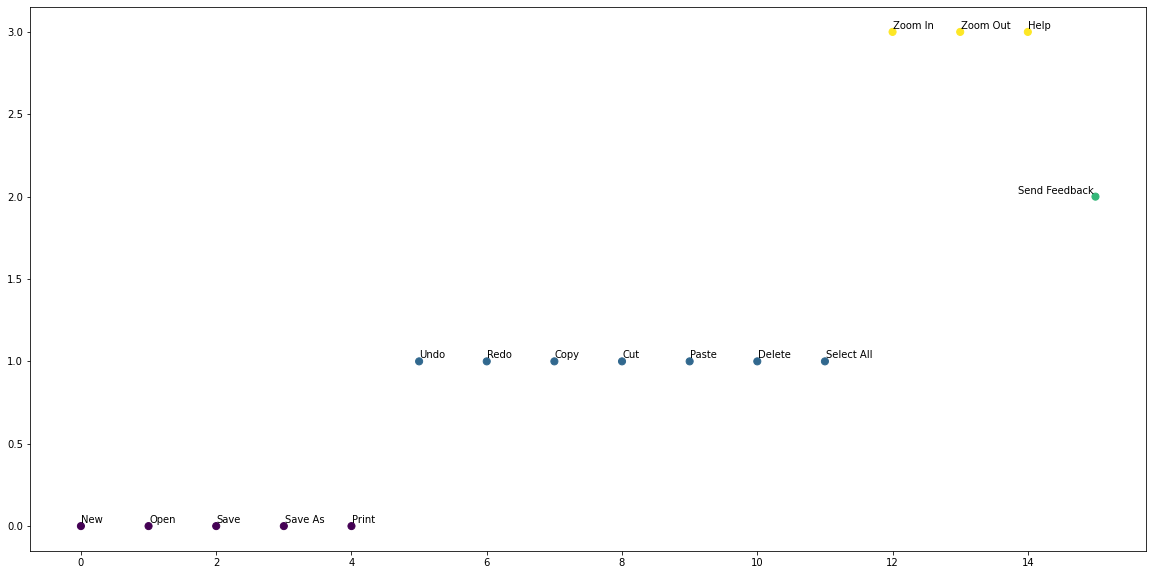

In [74]:
command_list = ['New', 'Open', 'Save', 'Save As', 'Print','Undo', 'Redo', 'Copy', 'Cut', 'Paste', 'Delete', 'Select All', 'Zoom In', 'Zoom Out', 'Help', 'Send Feedback']

number_of_nodes = len(command_list)
nodes_list_index = list(range(number_of_nodes))
n_clusters = int(np.ceil(np.log2(number_of_nodes)))

node_embeddings = np.array([model.wv.get_vector(i) for i in command_list])

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(node_embeddings) #kmeans
node_colors = kmeans.labels_


figure = plt.gcf() # get current figure
figure.set_size_inches(20, 10)
plt.scatter(nodes_list_index,node_colors,c=node_colors, s=50, cmap='viridis')
texts = [plt.text(nodes_list_index[i], node_colors[i], txt , ha='center', va='center') for i, txt in enumerate(command_list)]
adjust_text(texts) #adjusting annotations

In [75]:
wordsim('Help', 'Send Feedback')

array([[0.36233255]], dtype=float32)

In [77]:
wordsim('Excel Help', 'Send Feedback')

array([[0.38091004]], dtype=float32)

In [79]:
wordsim('Versions Help', 'Send Feedback')

array([[0.99977964]], dtype=float32)

In [ ]:
#TODO: Add NLP in some stages!